### concat data(position_data, forceplate_data)

フォースプレートデータと3d_position_dataの同期

In [4]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

#　フォースプレートのデータと骨格座標データを読み込む
def read_data(number:int) -> pd.DataFrame:
    '''
    number: int
    3d_position_data.csvとforceplateデータを読み込む
    '''
    force_data_path = os.path.join("row_data", "forceplate",f"{number}.csv")
    df_forceplate = pd.read_csv(force_data_path,index_col=0)
    df_forceplate.index = df_forceplate.index.astype(int)
    df_forceplate = df_forceplate[["Force:X", "Force:Y", "Force:Z"]]

    df_3d_path = os.path.join("row_data", "position_data", f"side_{number}",'3d_position_data.csv')
    df_3d = pd.read_csv(df_3d_path,index_col=0)
    return df_3d,df_forceplate

def swap_columns(data:pd.DataFrame, n:int) -> pd.DataFrame:
  '''
  x : 進行方向
  y : 垂直方向
  z : 深度方向
  '''
  df = data.copy()
  # 斜めorサイドターン
  if n >= 147:
    force_x = df['Force:Y']
    force_y = df['Force:Z']
    force_z = df['Force:X']
  # 前後
  else:
    force_x = df['Force:X']
    force_y = df['Force:Z']
    force_z = df['Force:Y']

  df['Force:X'] = force_x
  df['Force:Y'] = force_y
  df['Force:Z'] = force_z

  return df

In [5]:
#　フォースプレートのデータと骨格座標データを結合する
def concat_data(df1:pd.DataFrame,df2:pd.DataFrame,std_frame1:int,std_frame2:int,cam1_fps:int,cam2_fps:int) -> pd.DataFrame:
    '''
    df1: forceplate_data
    df2: 3d_position_data
    std_frame1: forceplate_dataの接地フレーム
    std_frame2: 3d_position_dataの接地フレーム
    cam1_fps:forceplateのfps
    cam2_fps:3d_position_dataのfps
    '''

    n = min(len(df1),len(df2))
    df = pd.DataFrame()
    for i in range(n):
        frame1 = df1.index[i]
        frame2 = synchronize_data(std_frame1,std_frame2,cam1_fps,cam2_fps,frame1)
        try:
            df_1 = df1[df1.index==frame1]
            df_2 = df2[df2.index==int(frame2)].set_index(df_1.index,drop=True)
            df = pd.concat([df,pd.concat([df_1,df_2],axis=1)],axis=0)
        except:
            pass
    return df

def process_dataframe(df):
    # # Set 'Sample #' as the index of the DataFrame
    df.index = df.index.astype(int)

    # Calculate the difference between consecutive indices
    df['Index_Diff'] = df.index.to_series().diff()

    # Identify where the difference is not 1 (indicating a gap in the sequence)
    gap_indices = df.index[df['Index_Diff'] != 1].tolist()

    # Add the start and end indices for completeness
    gap_indices = [df.index.min() - 1] + gap_indices + [df.index.max() + 1]

    # Initialize a list to store the slices of the DataFrame that meet the condition
    df_list = []

    # Loop over the gaps and slice the DataFrame
    for start, end in zip(gap_indices[:-1], gap_indices[1:]):
        df_slice = df.loc[start+1:end-1]

        # If the slice has 10 or more rows, add it to the list
        if len(df_slice) >= 10:
            df_list.append(df_slice)

    # Concatenate all the slices into a single DataFrame
    df_result = pd.concat(df_list)

    # Find the gaps in the index sequence
    gap_starts = df.index[df['Index_Diff'] > 1]
    
    return df_result

#　異なるfpsの動画のフレームを同期させる
def synchronize_data(std_frame1:int, std_frame2:int, cam1_fps:int, cam2_fps:int, frame1:int) -> int:
    frame2 = (frame1 - std_frame1) * cam2_fps / cam1_fps + std_frame2
    return int(round(frame2+0.1))

#　骨格座標データにおける接地フレームを取得する
def contact_frame(n:int)->int:
    '''
    n:動画番号
    3d_position_data.csvにおける接地フレームを取得する
    '''
    data_path = os.path.join("csv", "contact_plate.csv")
    df_contact = pd.read_csv(data_path, index_col=0)
    contact_frame = df_contact.loc[f'side_{n}',"frame"]
    return int(contact_frame)

#　フォースプレートのデータにおける接地フレームを取得する
def detect_contact_frame(df)->int:
    '''
    number:動画番号
    forceplateデータにおける接地フレームを取得する
    '''
    df = df.astype(float)
    df = df.loc[df["Force:Y"] > abs(float(0))]
    df = process_dataframe(df)
    return int(df.index[0]-1)

def syncro_frames()->pd.DataFrame:
    data_path = os.path.join("csv","syncro_frames.csv")
    df_syncro = pd.read_csv(data_path, index_col=0)
    return df_syncro

同期データの設定

In [6]:
df_syncro = syncro_frames()

SAVE_PATH = 'concat_data'
os.makedirs(SAVE_PATH,exist_ok=True)

CAM2_FPS = 1000

for n in range(131,168):
    # データの読み込み
    df1,df2 = read_data(n)
    df2 = swap_columns(df2, n)

    # force_plateのデータから接地時間を計算
    df2['second'] = [i/1000 for i in range(len(df2))]

    # 接地フレームの取得
    std_frame1 = contact_frame(n)
    std_frame2 = detect_contact_frame(df2)

    cam1_fps = int(df_syncro.loc[df_syncro.index==n,'fps_side'])
    df = concat_data(df1, df2, std_frame1 ,std_frame2, cam1_fps, CAM2_FPS)
    
    df = df.astype(float)
    df = df.loc[df["Force:Y"] > abs(float(0))]
    df.to_csv(f"{SAVE_PATH}/concat_data_{n}.csv")

### 各データのグラフの描画

In [7]:
def cal_force(df:pd.DataFrame,columns:list)->pd.DataFrame:
    '''
    df: pd.DataFrame
    columns: list
    '''
    df['Force'] = (df[columns[0]]**2 + df[columns[1]]**2 + df[columns[2]]**2)**0.5
    return df

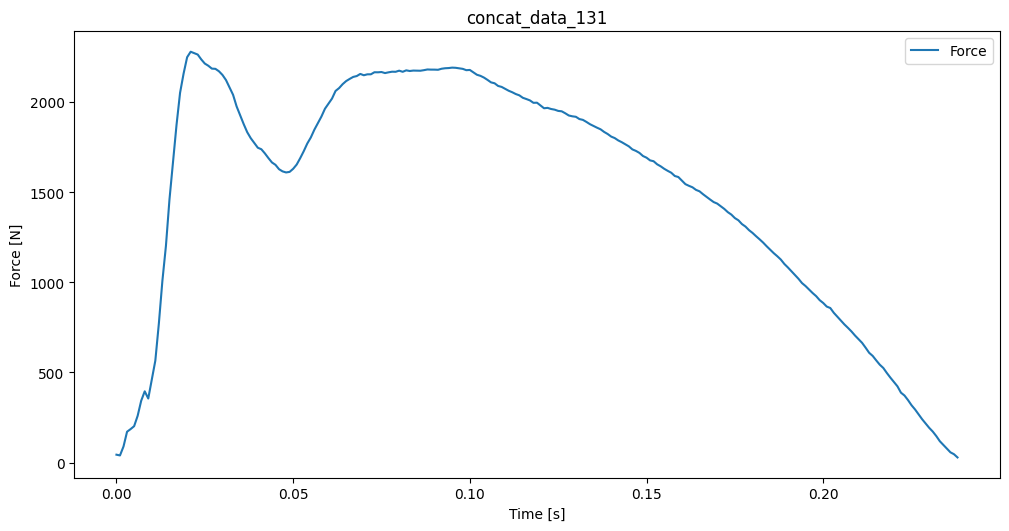

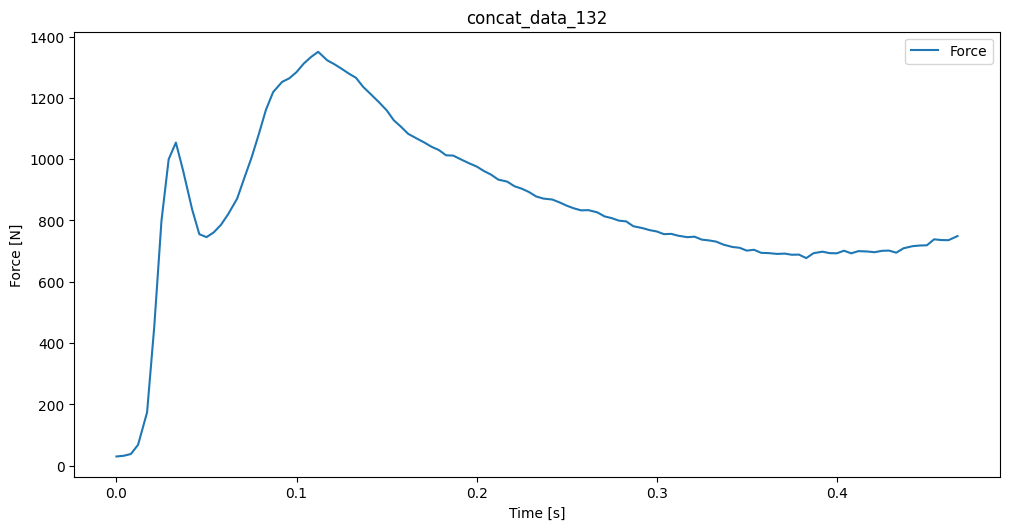

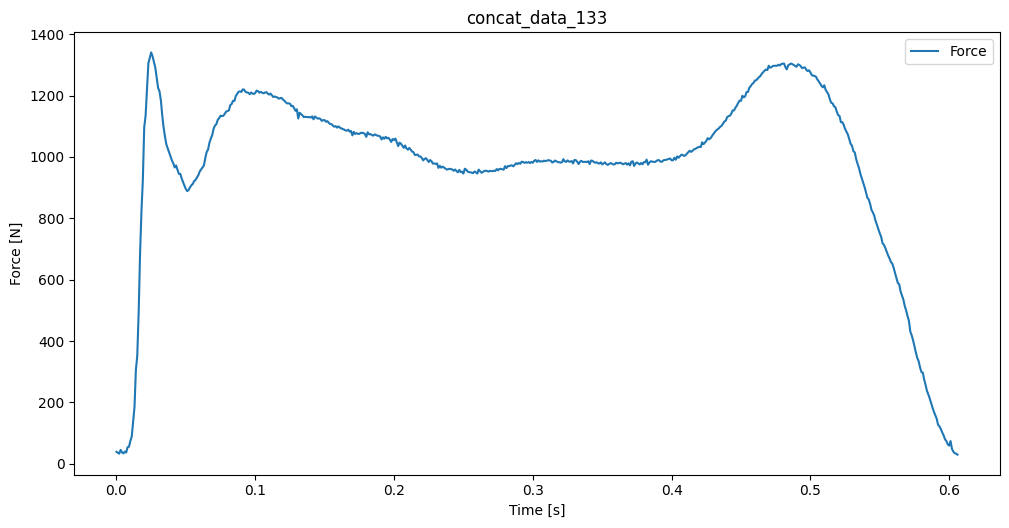

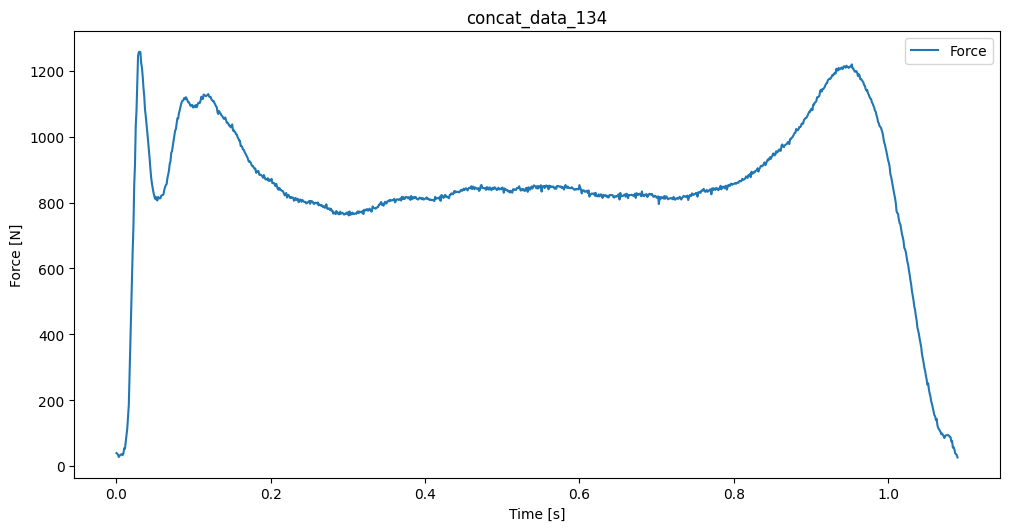

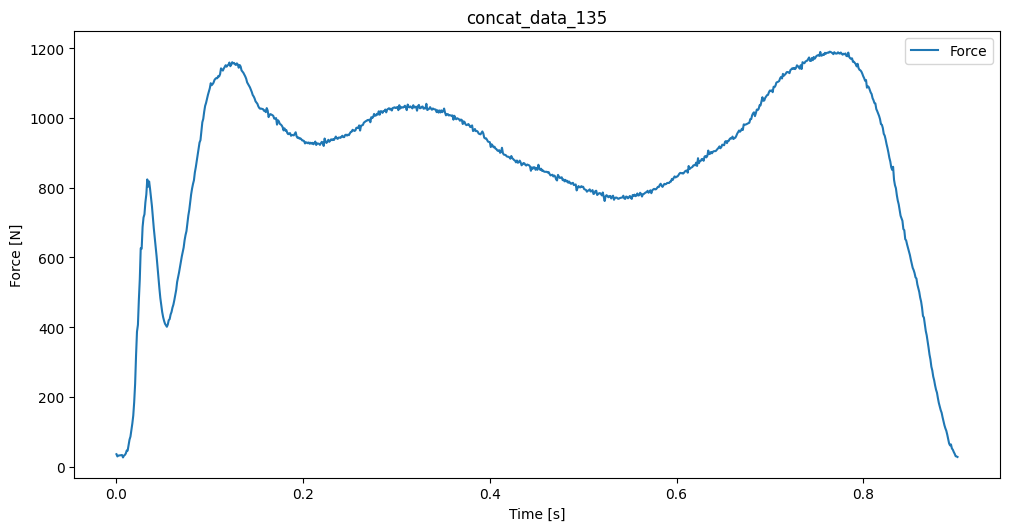

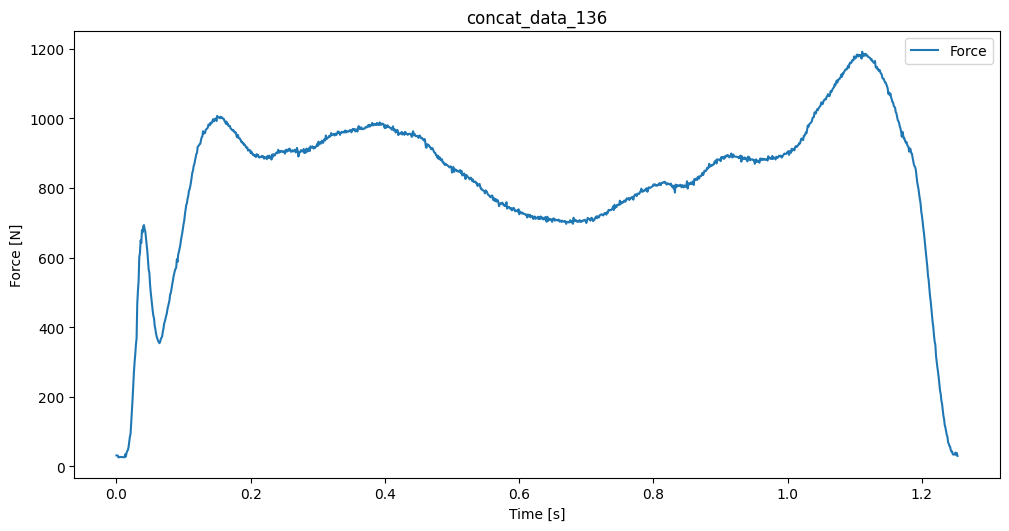

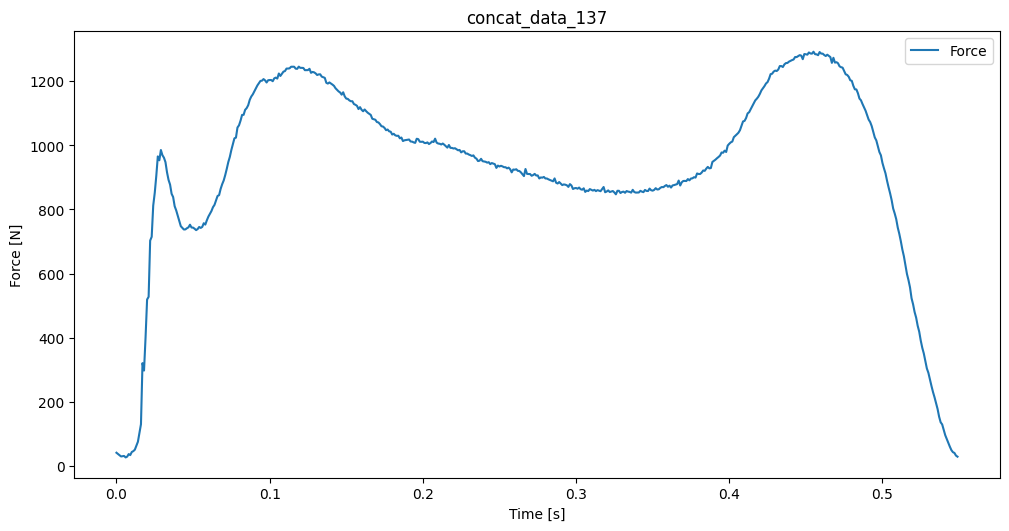

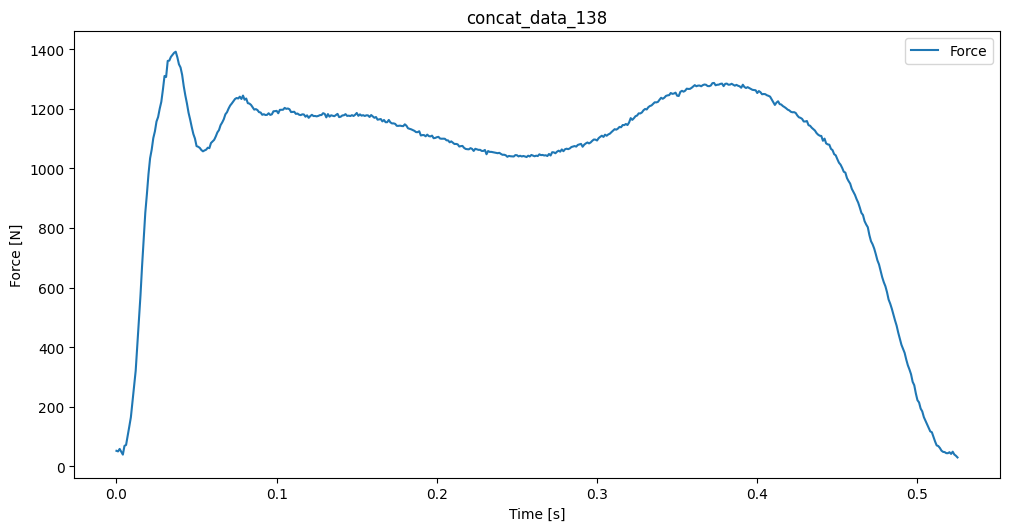

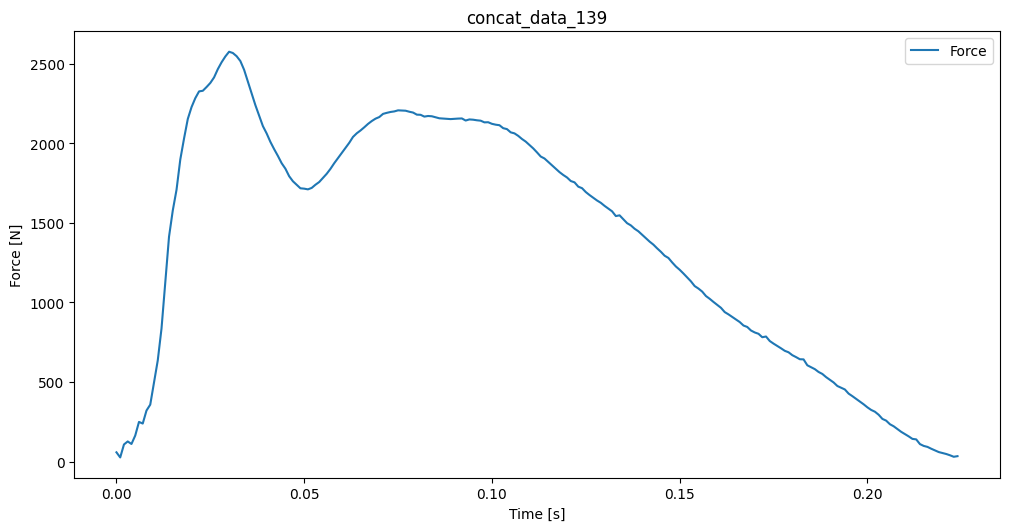

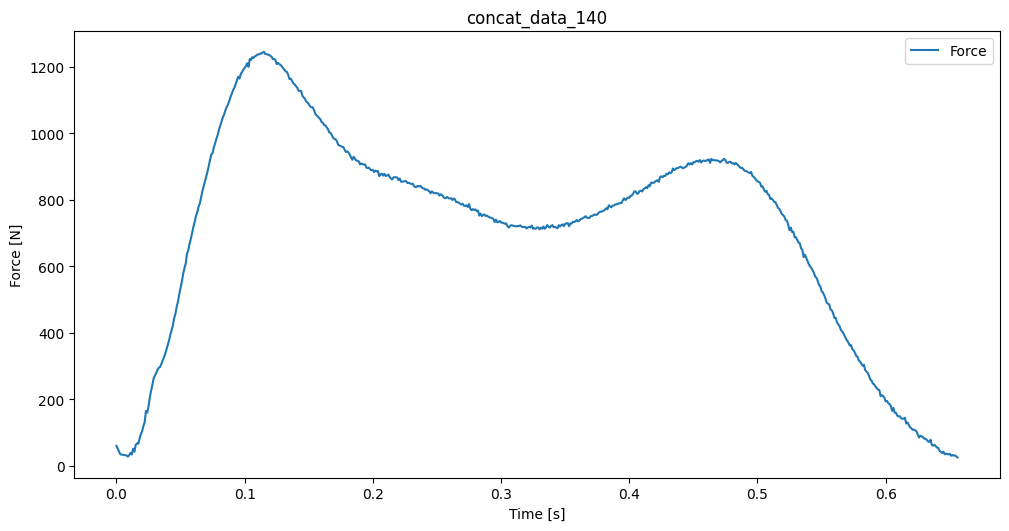

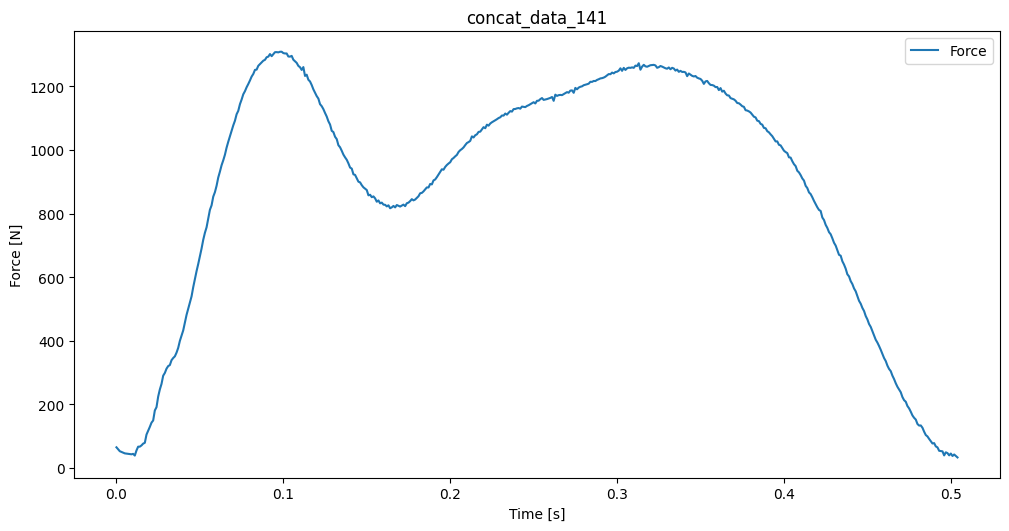

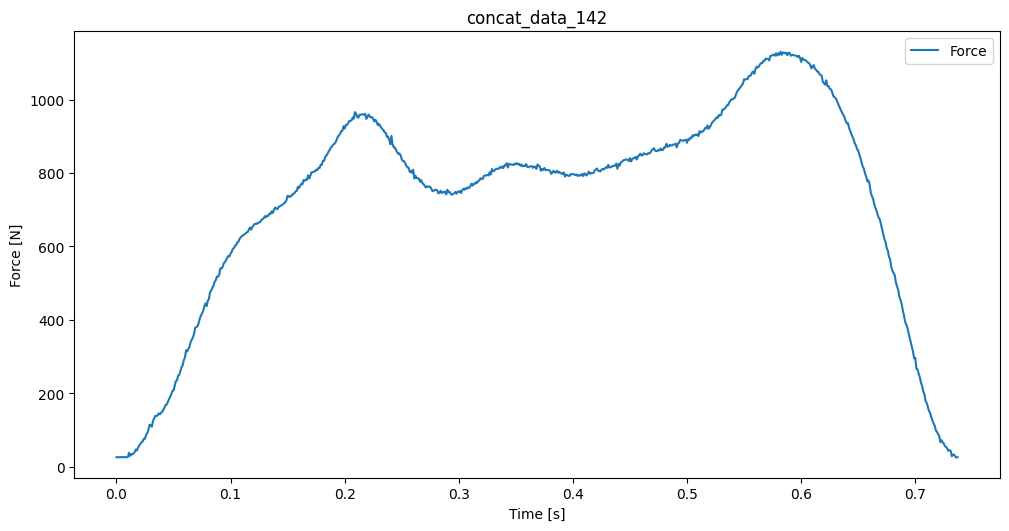

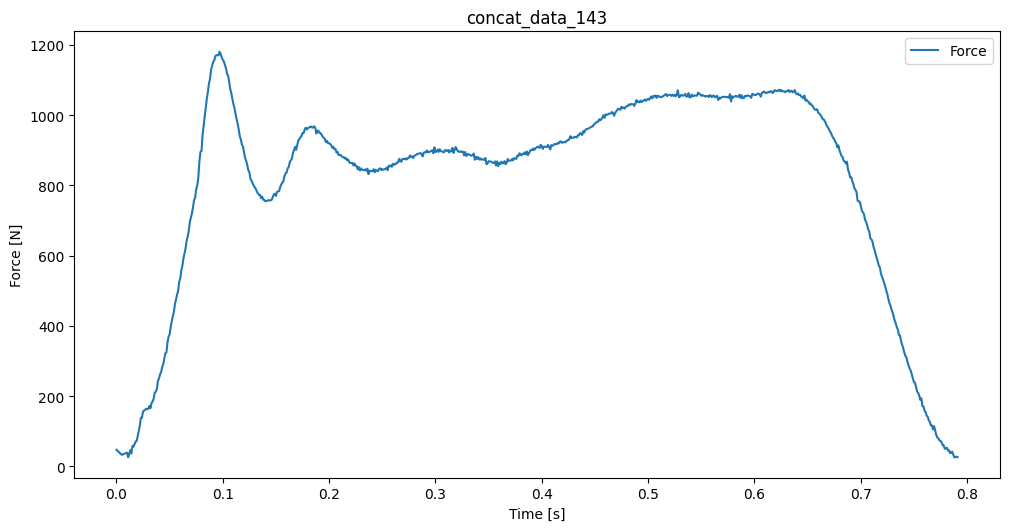

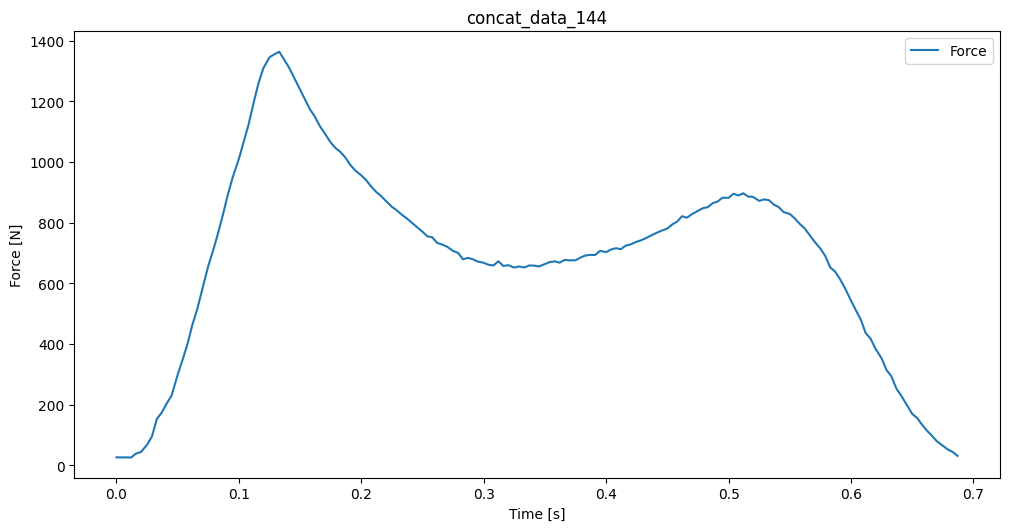

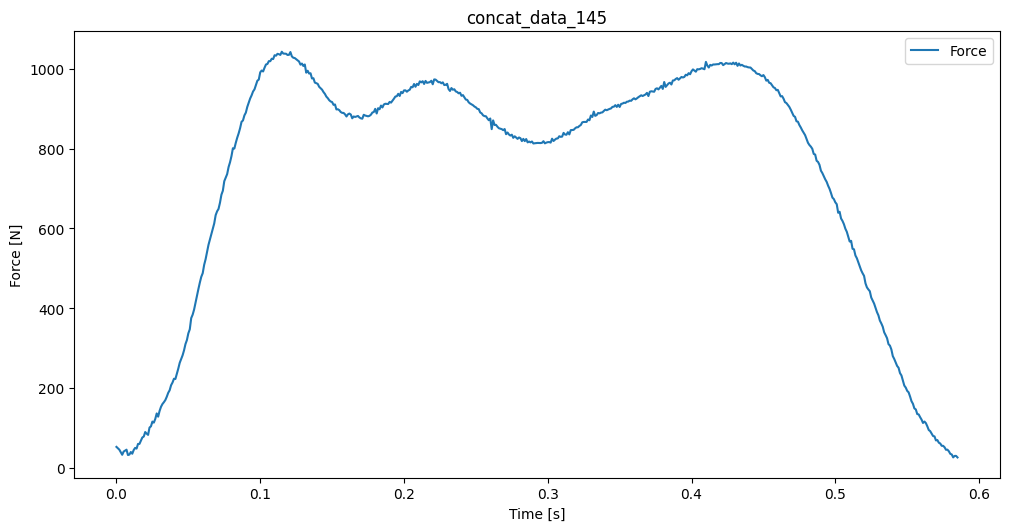

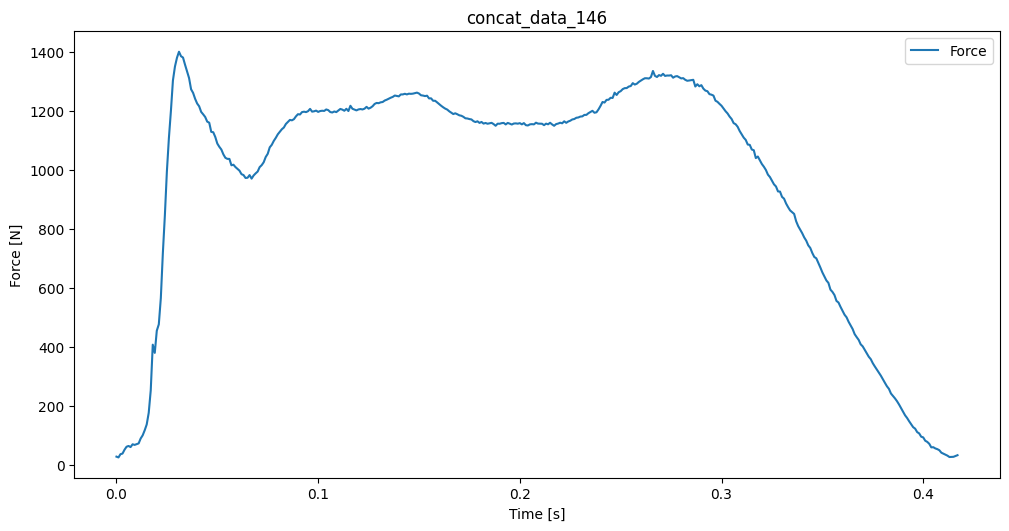

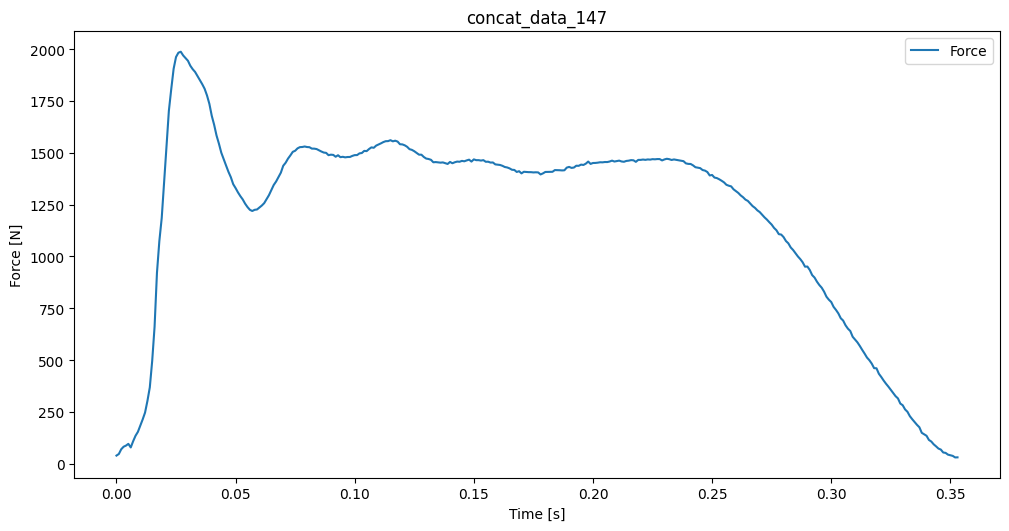

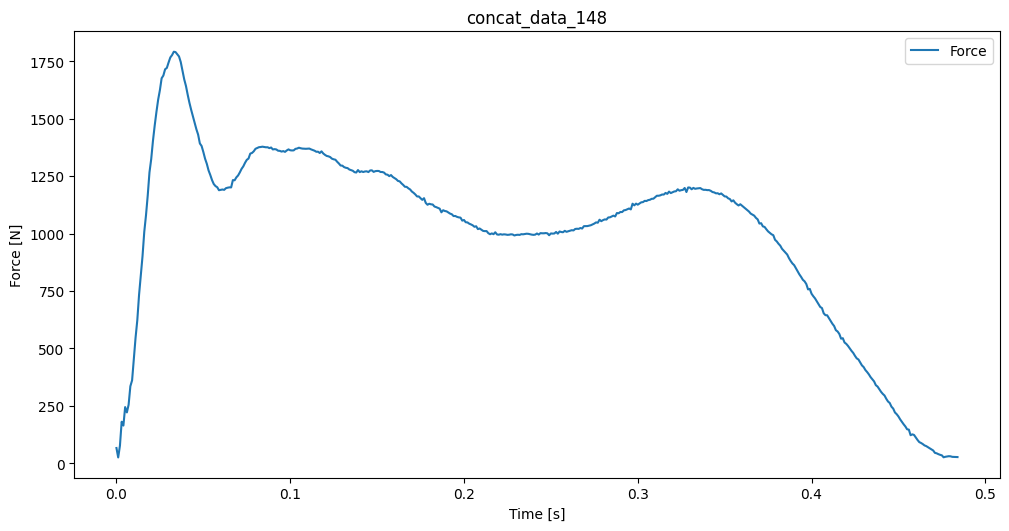

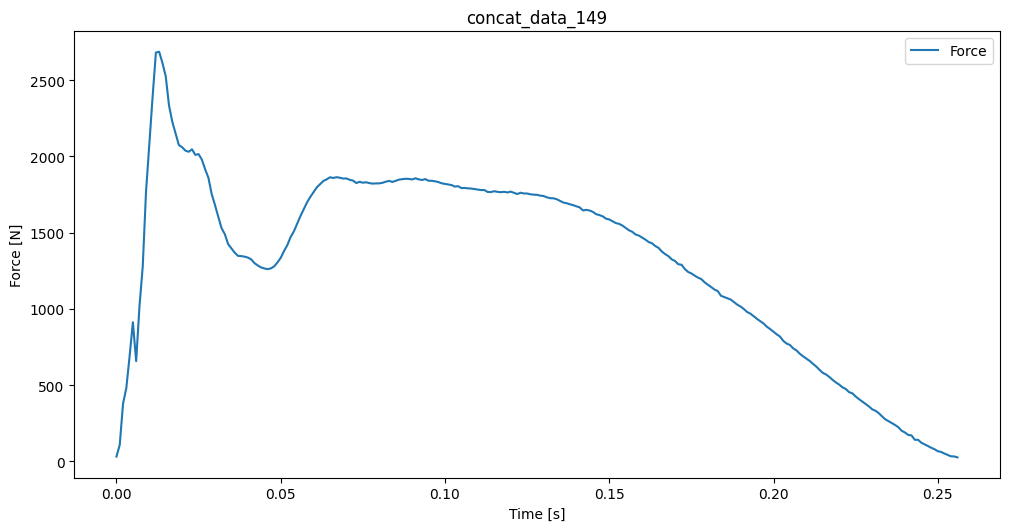

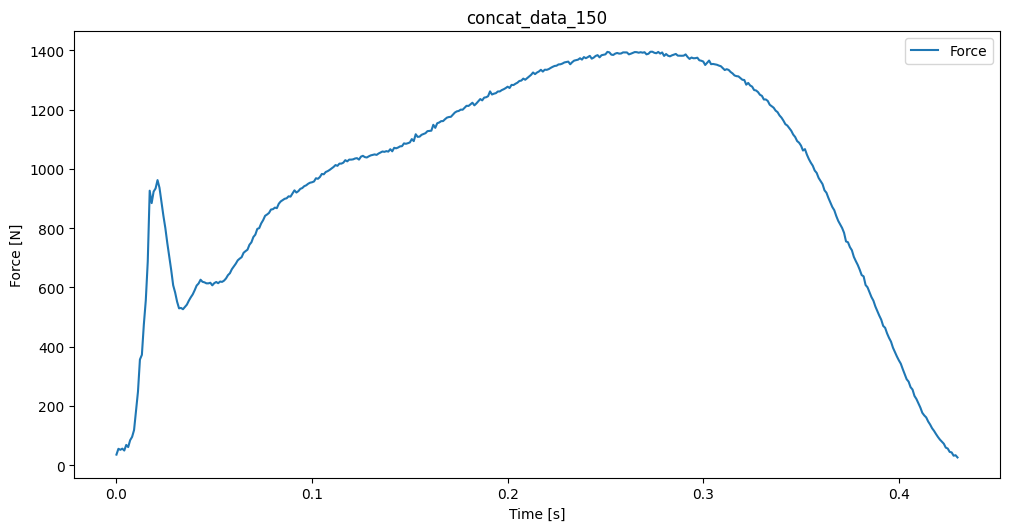

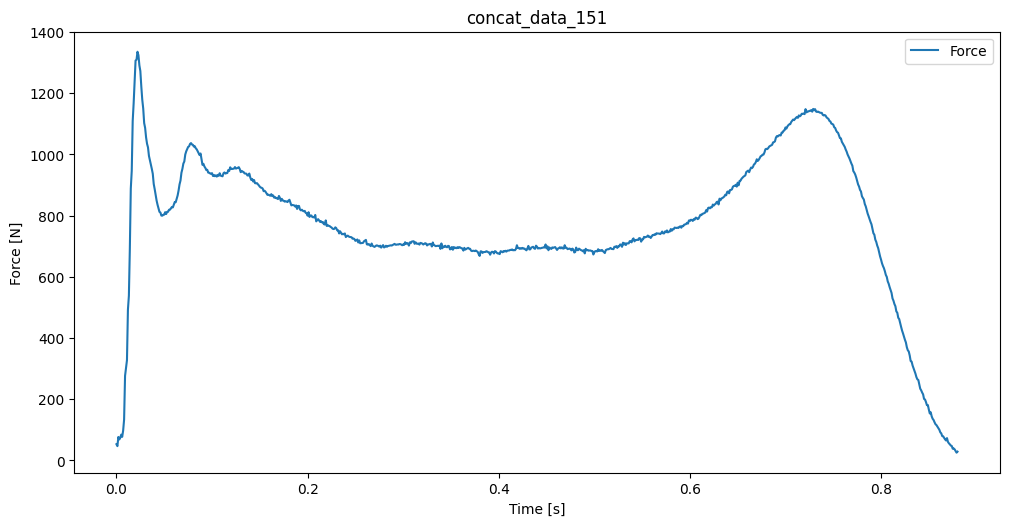

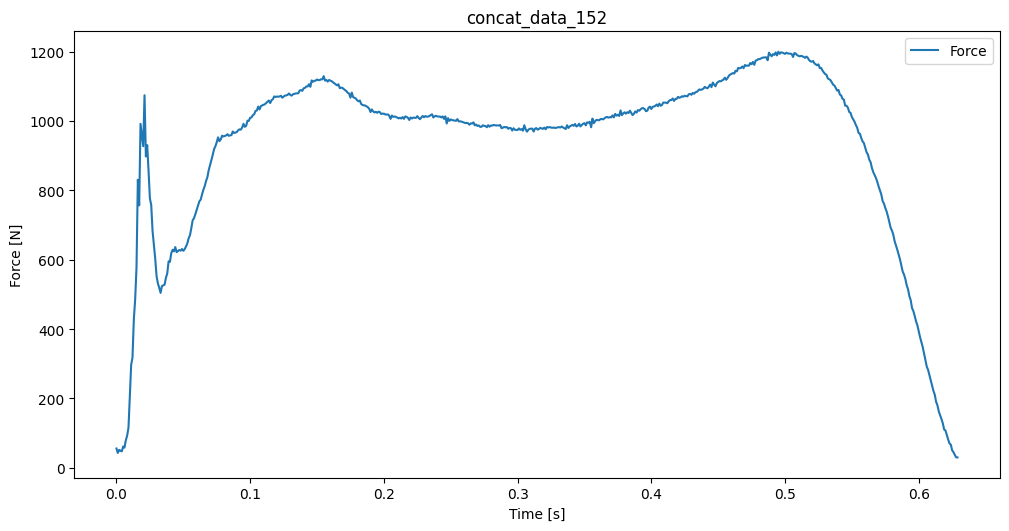

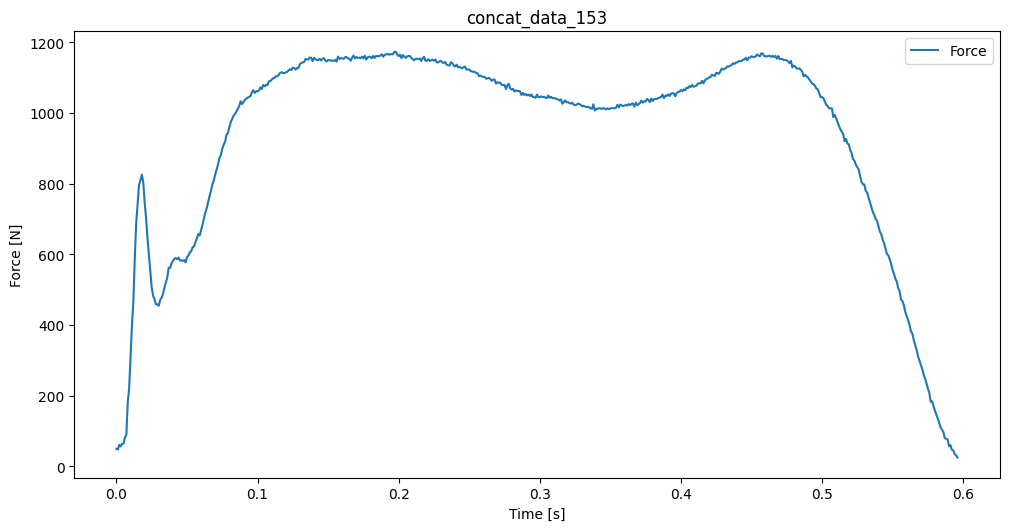

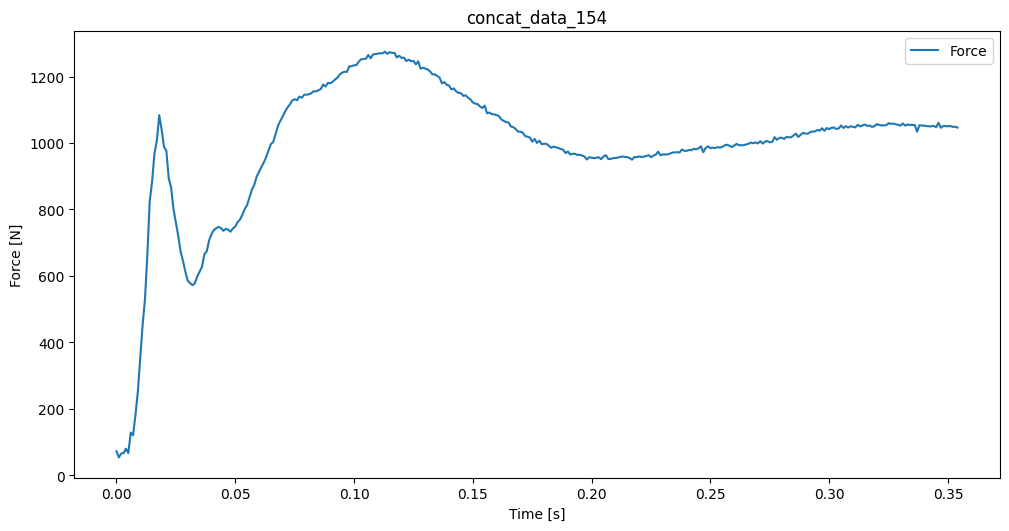

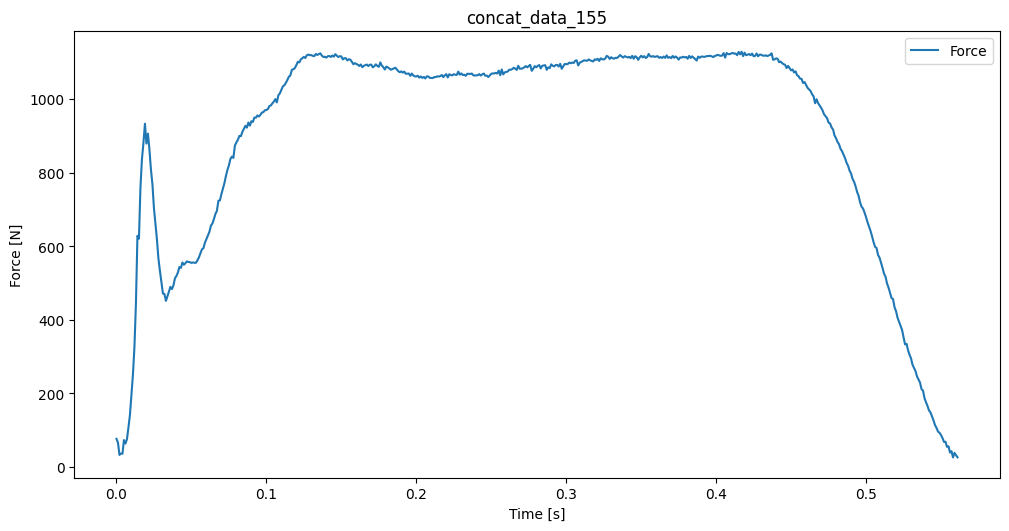

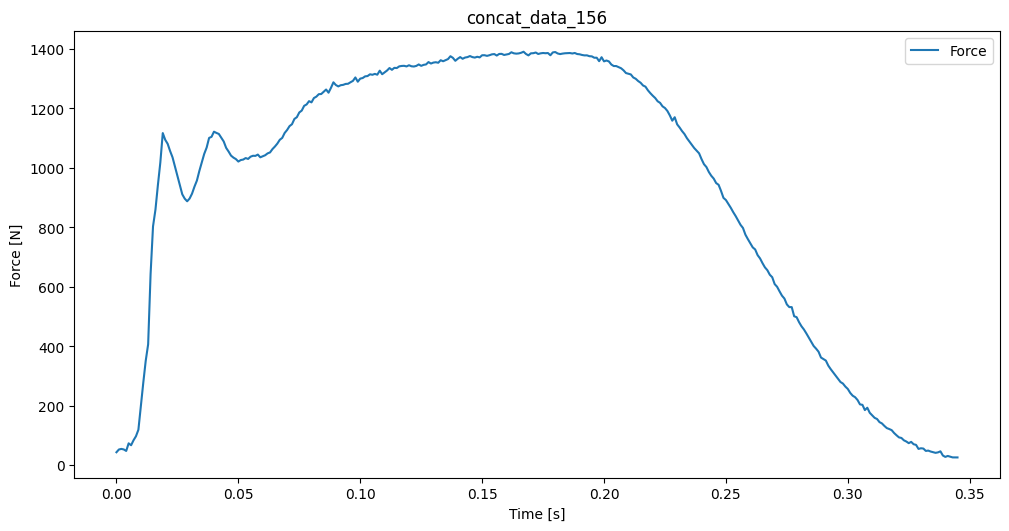

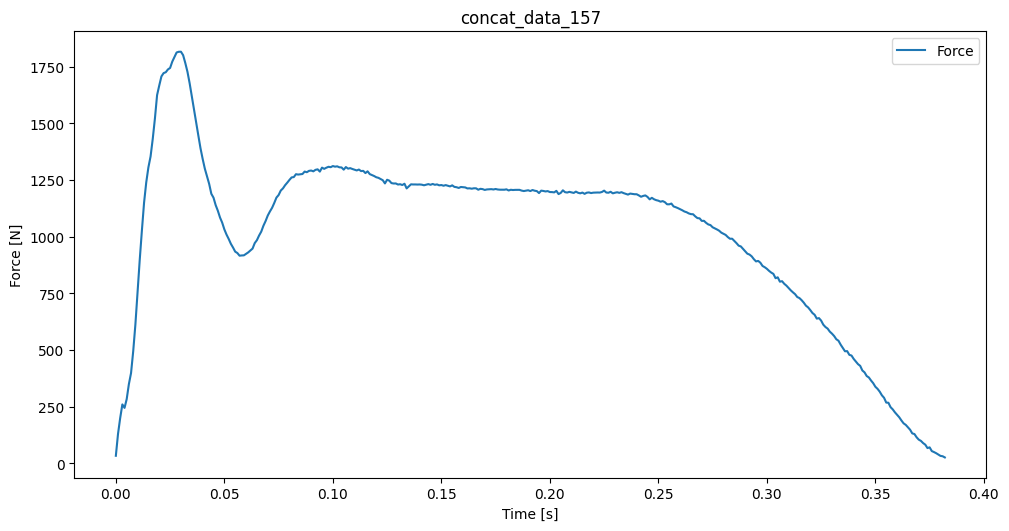

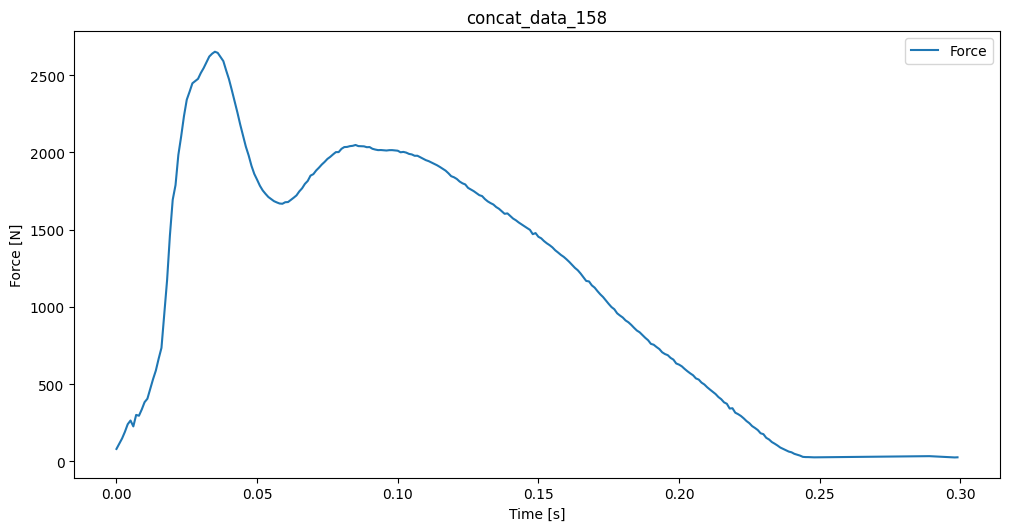

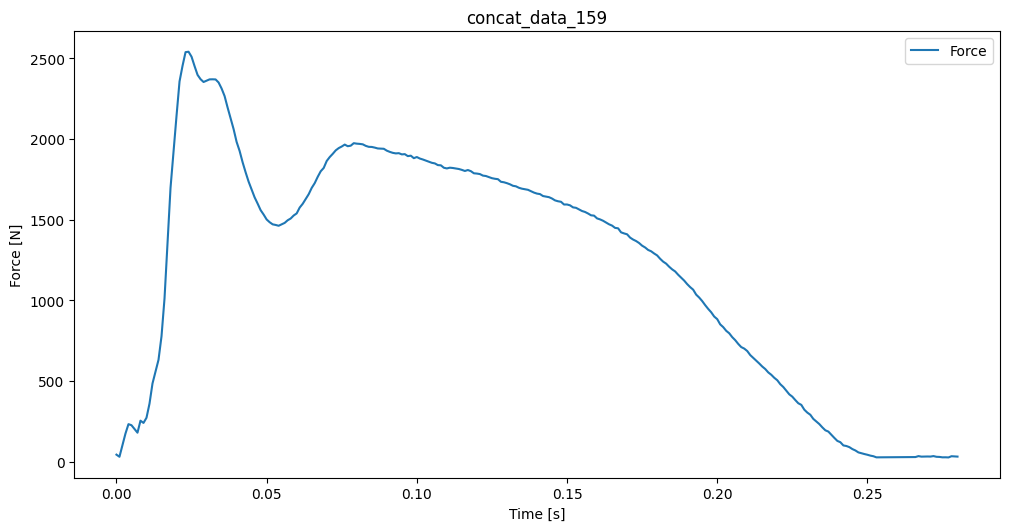

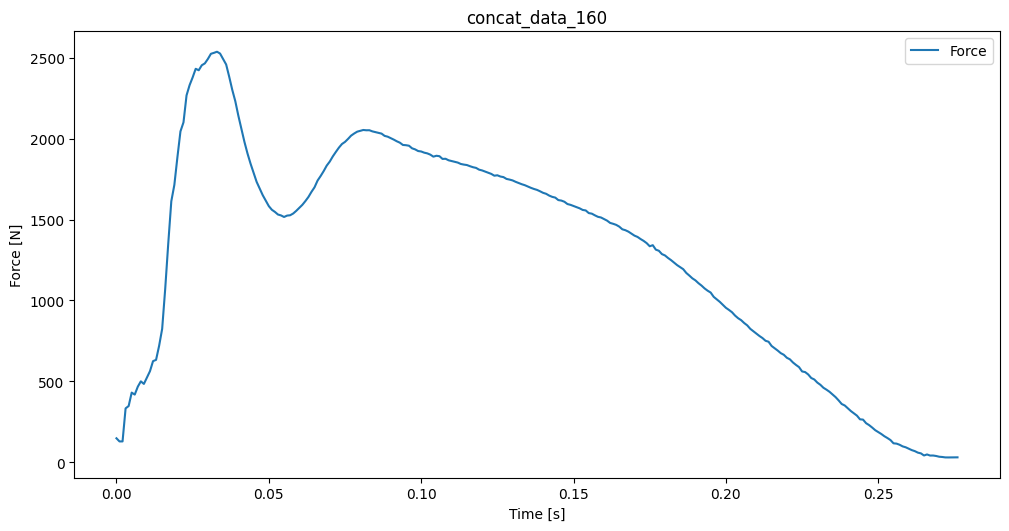

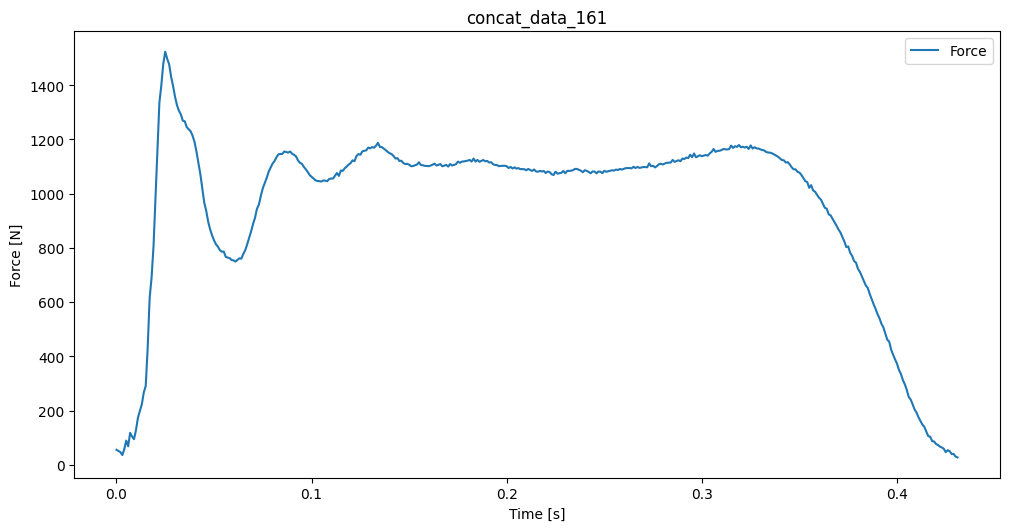

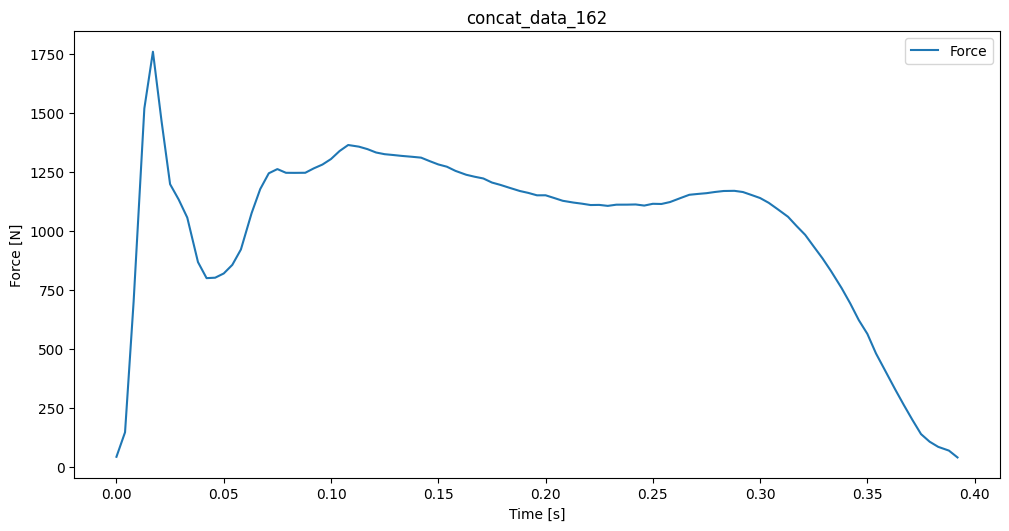

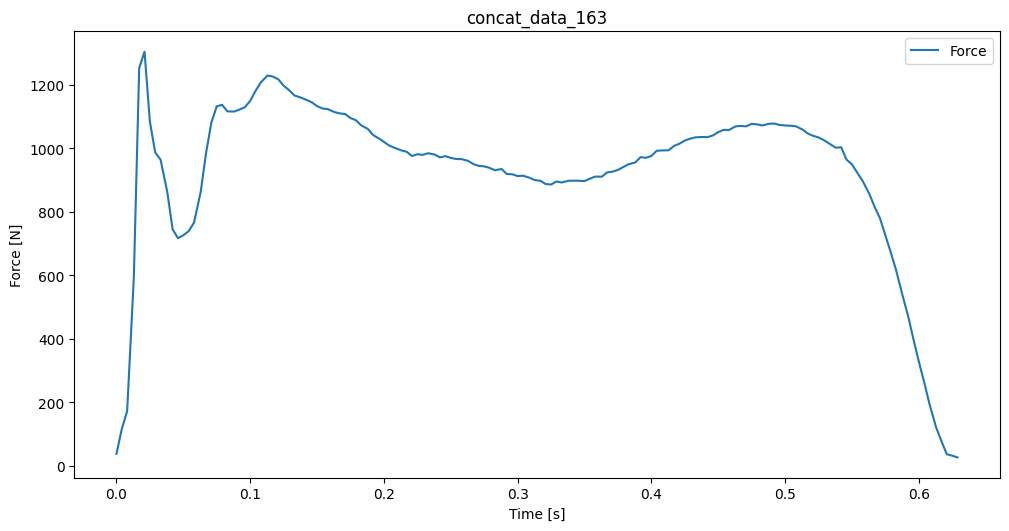

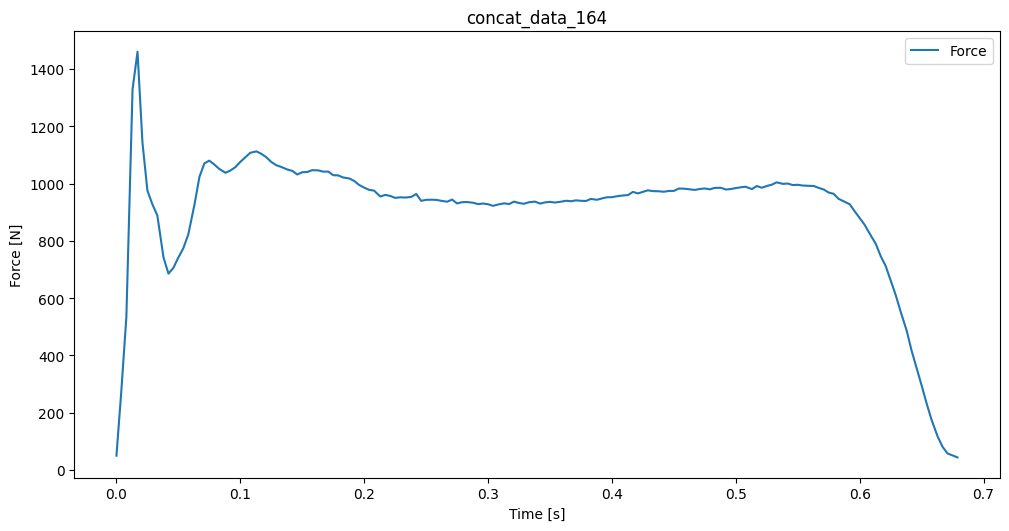

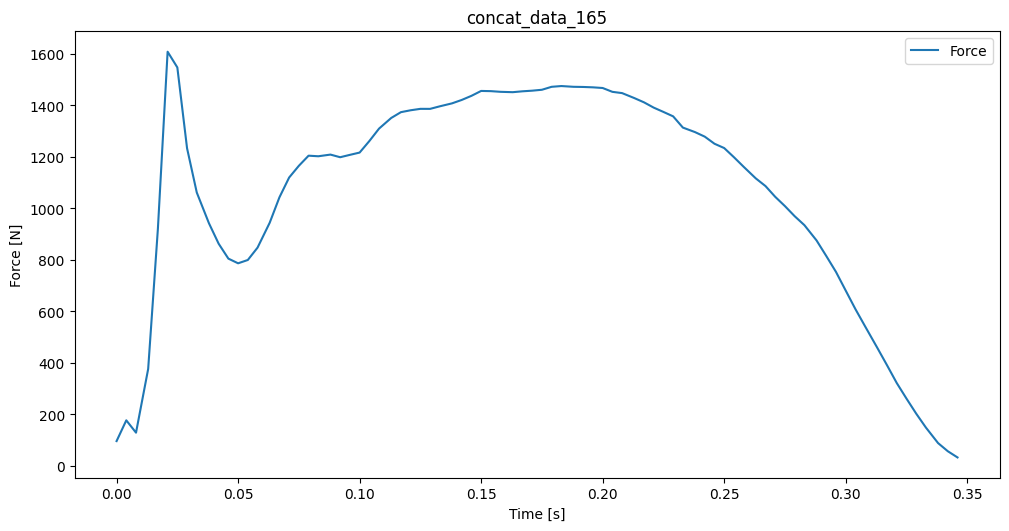

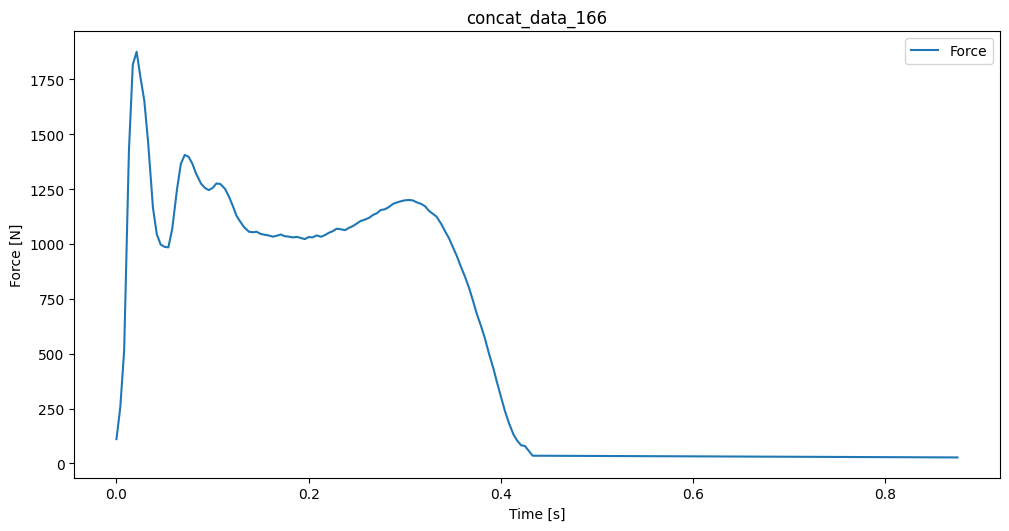

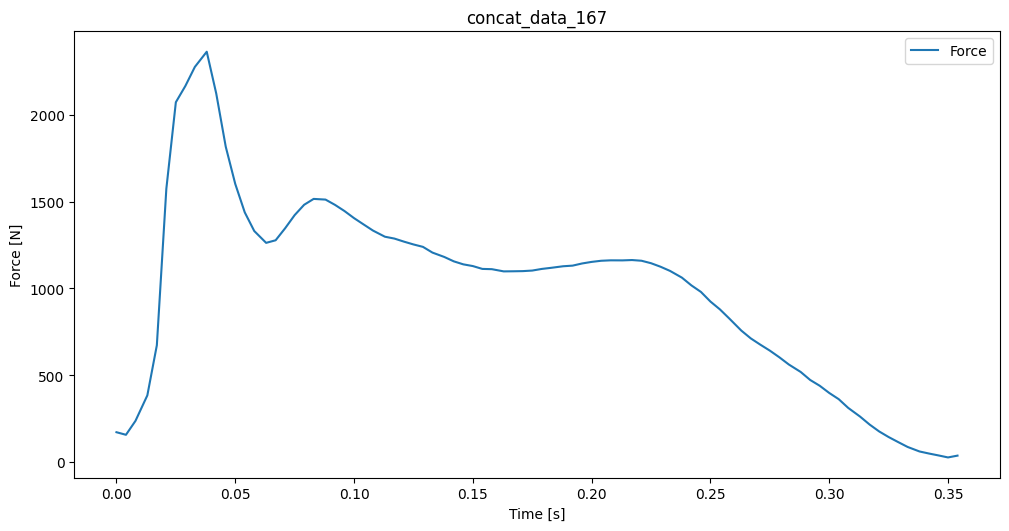

In [8]:
import os
from natsort import natsorted
import matplotlib.pyplot as plt

data_folder_path = 'concat_data'
data_files = natsorted(os.listdir(data_folder_path))

save_path = 'graph'
os.makedirs(save_path, exist_ok=True)

columns = ['Force:X', 'Force:Y', 'Force:Z', 'second']
for data_file in data_files:
    data_path = os.path.join(data_folder_path, data_file)
    df = pd.read_csv(data_path, index_col=0)
    df = df[columns]
    force = cal_force(df, columns)
    fig, ax = plt.subplots(figsize=(10, 5))
    time = df['second'].values - df['second'].values[0]
    ax.plot(time, df['Force'], label='Force')
    plt.tight_layout()
    plt.xlabel('Time [s]')
    plt.ylabel('Force [N]')
    plt.title(data_file[:-4])
    plt.legend()
    plt.savefig(f'{save_path}/{data_file[:-4]}.png')
    plt.show()